In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

frames_folder = 'images/train'
empty_parking_folder = 'markup'
output = 'output'

In [3]:
def clahe_contrast(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab_image)
    
    # Apply CLAHE to the L channel (luminance)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(22, 22))
    l_clahe = clahe.apply(l)
    
    # Merge back the LAB channels
    lab_clahe = cv2.merge((l_clahe, a, b))
    image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    return image

In [4]:
def match_features(des1, des2, treshold = 10):
    """
    Match SIFT descriptors using BFMatcher with ratio test.
    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    good = []
    good_matches = []
    
    for m, n in matches:
        if m.distance < treshold * n.distance:
            good_matches.append(m)
            good.append([m])
            
    return good_matches, good 

In [5]:
def is_parking_space_empty(good_matches, threshold=10):
    return len(good_matches) > threshold

In [6]:
def upscale_image(image, scale_factor=2):
    height, width = image.shape[:2]
    new_size = (int(width * scale_factor), int(height * scale_factor))
    upscaled_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return upscaled_image

In [7]:
def detect_parking_markings(image_path, kernel_size=3):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    image = upscale_image(image, 10)
    # image = adjust_contrast(image)
    image = clahe_contrast(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    # Apply Gaussian Blur to reduce noise (optional)
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Apply Sobel Edge Detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=kernel_size)  # Horizontal edges
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=kernel_size)  # Vertical edges

    # Combine the two gradients
    sobel_combined = cv2.magnitude(sobel_x, sobel_y)

    # Normalize the edge image to uint8
    sobel_combined = cv2.convertScaleAbs(sobel_combined)

    # Optional: Apply Thresholding to keep strong edges
    _, thresholded_edges = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY)

    return thresholded_edges

In [8]:
def detect_orb_features(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def detect_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [9]:
def upscale_image(image, scale_factor=2):
    height, width = image.shape[:2]
    new_size = (int(width * scale_factor), int(height * scale_factor))
    upscaled_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return upscaled_image

In [10]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

In [11]:
def main():
    # Load templates and extract features
    template_files = sorted([f for f in os.listdir(empty_parking_folder) if f.endswith('.jpg') or f.endswith('.png')])
    templates = []
    for template_file in template_files:
        template_path = os.path.join(empty_parking_folder, template_file)
        template_image = cv2.imread(template_path)

        edge_image = detect_parking_markings(template_path)

        if template_file != '5.png':
            template_image = upscale_image(template_image, 4)
        else:
            template_image = upscale_image(template_image, 0.4)
            
        template_image = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
        
        kp_temp, des_temp = detect_sift_features(template_image)
        templates.append({
            'image': template_image,
            'keypoints': kp_temp,
            'descriptors': des_temp,
            'name': template_file
        })

        sh = cv2.drawKeypoints(template_image, kp_temp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        show_in_row([sh, edge_image])
    
    # Get list of frame files
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg') or f.endswith('.png')])
    
    for frame_file in frame_files:
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = upscale_image(frame, 4)
        
        if frame is None:
            print(f"Error loading frame {frame_path}")
            continue
        
        # Extract features from the frame
        kp_frame, des_frame = detect_sift_features(frame)
        
        # For each parking space template, perform matching
        for idx, template in enumerate(templates):
            # Match features
            good_matches, good = match_features(template['descriptors'], des_frame)
            
            img3 = cv2.drawMatchesKnn(template['image'],template['keypoints'],frame,kp_frame,good,None,flags=2)
            show_in_row([img3])
            
            if len(good) > 5:
                src_pts = np.float32([template['keypoints'][m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
                dst_pts = np.float32([kp_frame[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                matchesMask = mask.ravel().tolist()
                
                h,w = template['image'].shape
                # Take corners of the first image and transform them onto the second image
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)
            
                frame = cv2.polylines(frame,[np.int32(dst)],True,255,3, cv2.LINE_AA)
                # cv2.fillPoly(frame, [np.int32(dst)], color=(0, 0, 0))
                kp_frame, des_frame = detect_sift_features(frame)

                show_in_row([frame])
        # show_in_row([frame])
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output + '/' + frame_file, frame)


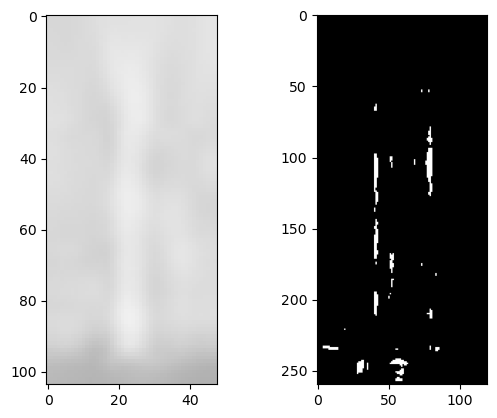

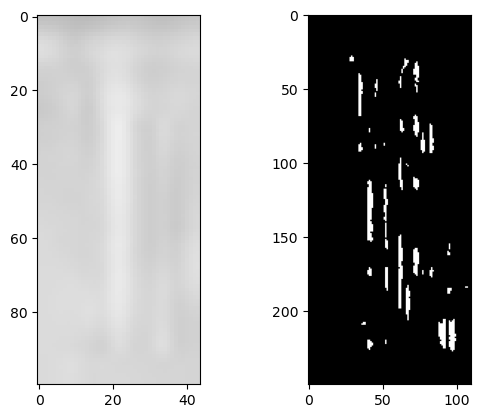

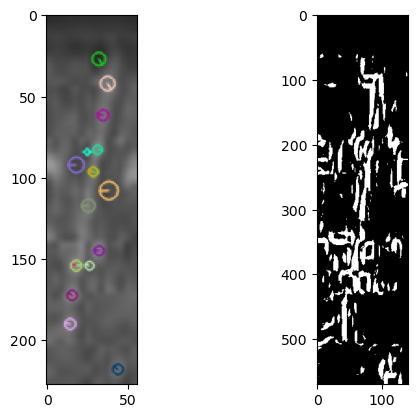

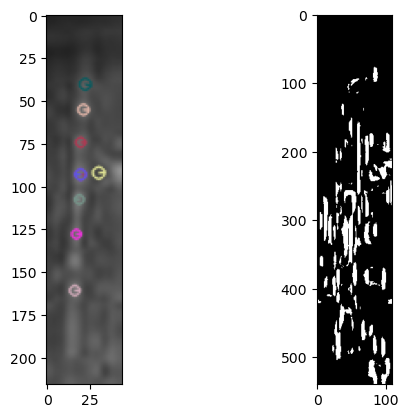

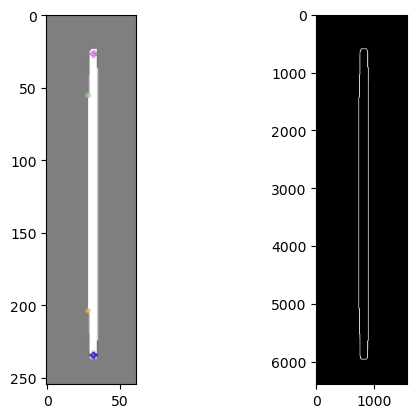

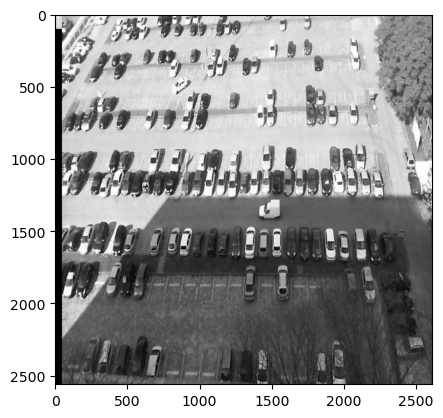

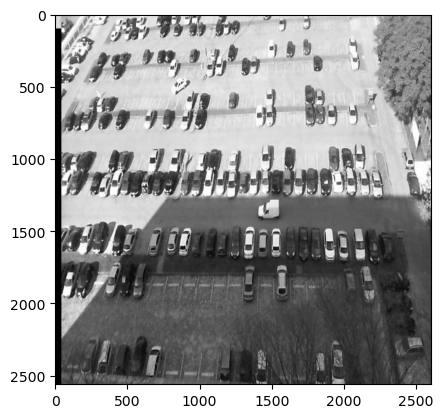

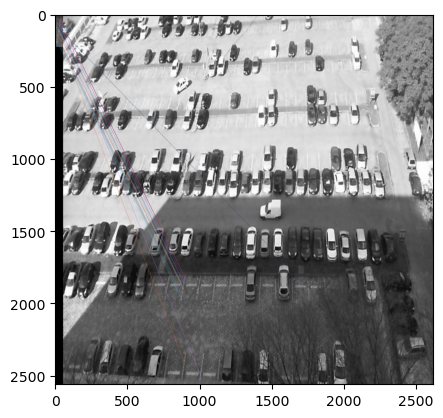

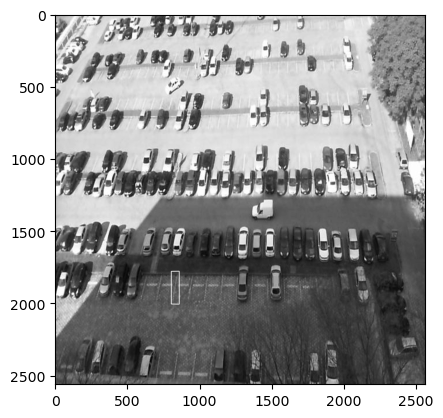

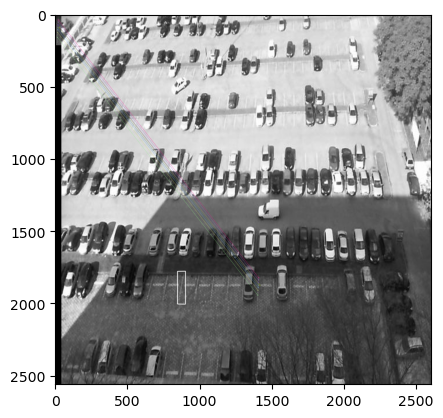

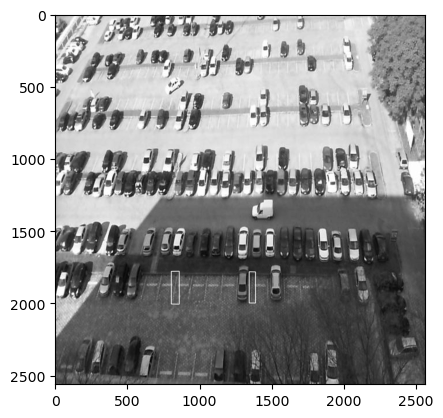

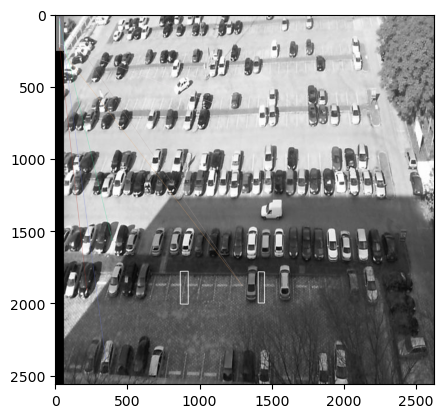

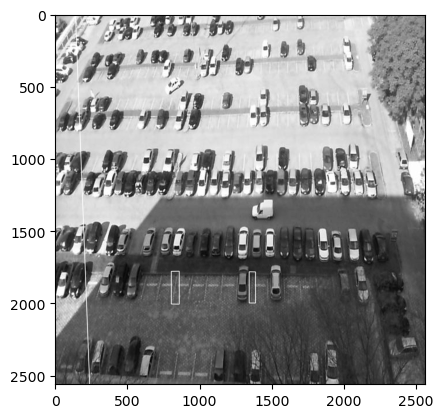

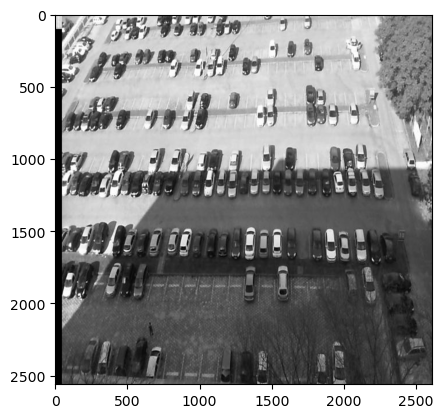

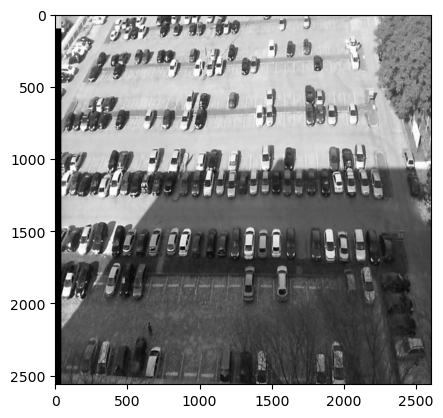

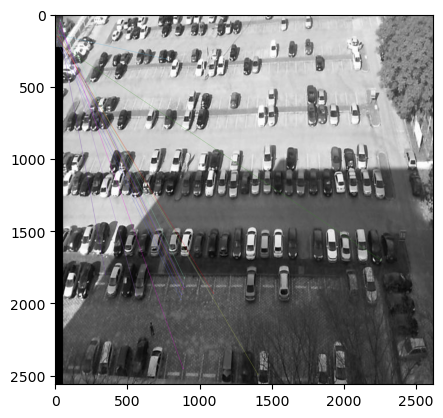

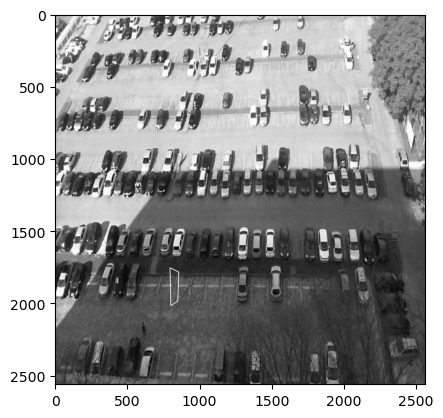

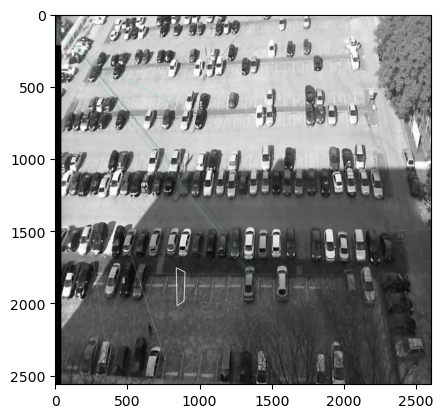

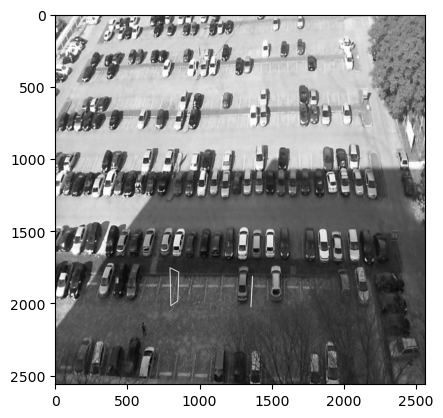

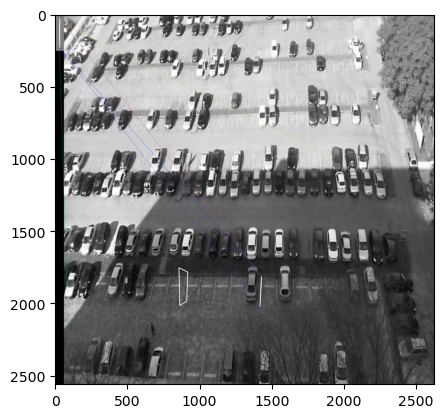

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [12]:
if __name__ == "__main__":
    main()